# Agglomerative clustering on credit card fraud detection

This notebook build a simple agglomerative clustering (AHC) framework to identify fraudlent credit card transactions. Different from XGBoost or other machine learning models commonly applied on an imbalanced dataset. AHC is an unsupervised learning algorithm which require no data label.

### Import Dataset and Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
import numpy as np
import time, copy, pickle
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer, classification_report, f1_score, roc_auc_score
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
tmp = df.Class.to_numpy()

In [36]:
df.shape

(284807, 31)

## Baseline Model

In [5]:
def cross_validation(classifier, x, y, fold=5): 
    class_rpt_mean = {'0':{'precision':0, 'recall':0, 'f1-score':0, 'support':0}, 
                             '1':{'precision':0, 'recall':0, 'f1-score':0, 'support':0},
                             'accuracy':0,
                             'macro avg':{'precision':0, 'recall':0, 'f1-score':0, 'support':0},
                             'weighted avg':{'precision':0, 'recall':0, 'f1-score':0, 'support':0}}
    roc_auc = 0
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)
    print(classifier)
    for tup in skf.split(x, y):
        print('============================== new fold ============================')
        x['pid'] = [i+1 for i in range(x.shape[0])]
        train_x = x.iloc[tup[0]]
        test_x = x.iloc[tup[1]]
        if (test_x[test_x.pid.isin(train_x.pid)].shape[0]!=0):
            print('data leakage')
            return False
        scaler = StandardScaler()
        train_x = scaler.fit_transform(train_x)
        print('fitting model')
        classifier.fit(train_x,y[tup[0]])
        print('predicting result')
        y_pred = classifier.predict(scaler.transform(test_x))
        y_pred_prob = classifier.predict_proba(scaler.transform(test_x))
        print('prediction distribution')
        print(pd.Series(y_pred).value_counts())
        class_rpt = classification_report(y[tup[1]], y_pred, output_dict=True)
        roc_auc += roc_auc_score(y[tup[1]], y_pred_prob[:, 1])/fold
        for label in ('0', '1', 'macro avg', 'weighted avg'):
            for metrics in ('precision', 'recall', 'f1-score', 'support'):
                class_rpt_mean[label][metrics] += class_rpt[label][metrics]/fold
        class_rpt_mean['accuracy'] += class_rpt['accuracy']/fold
    return class_rpt_mean, roc_auc

In [21]:
df_baseline=copy.deepcopy(df)
x = df_baseline.iloc[:,:-1]
y = df_baseline.iloc[:,-1]
xgb = XGBClassifier(random_state=0, n_jobs=-1)
xgb_baseline_class_rpt, xgb_baseline_roc_auc = cross_validation(xgb, x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)
============================== new fold ============================
fitting model
predicting result
prediction distribution
0    56886
1       76
Name: count, dtype: int64
============================== new fold ============================
fitti

In [22]:
xgb_baseline_class_rpt, xgb_baseline_roc_auc

({'0': {'precision': 0.9996483863284472,
   'recall': 0.9999472416158135,
   'f1-score': 0.9997977900629433,
   'support': 56863.0},
  '1': {'precision': 0.964272481447306,
   'recall': 0.7968253968253969,
   'f1-score': 0.8719423595239792,
   'support': 98.4},
  'accuracy': 0.9995962180977642,
  'macro avg': {'precision': 0.9819604338878767,
   'recall': 0.8983863192206052,
   'f1-score': 0.9358700747934613,
   'support': 56961.399999999994},
  'weighted avg': {'precision': 0.9995872272457302,
   'recall': 0.9995962180977642,
   'f1-score': 0.9995768215440497,
   'support': 56961.399999999994}},
 0.978489587458764)

### Feature selection - Filter Method

In [8]:
x = copy.deepcopy(df).iloc[:,:-1]
y = copy.deepcopy(df).iloc[:,-1]
mmsc = MinMaxScaler()
stdsc = StandardScaler()
mmsc.fit(x)
stdsc.fit(x)
mmscaled_x = pd.DataFrame(mmsc.transform(x), columns=x.columns)
stdscaled_x = pd.DataFrame(stdsc.transform(x), columns=x.columns)

In [9]:
def computeFeatureScore(x, y, stat_func):    
    score = SelectKBest(score_func=stat_func, k='all').fit(x,y).scores_
    score = pd.concat([pd.DataFrame(x.columns), pd.DataFrame(score)],axis=1)
    score.columns = ['feature', 'score']
    score.sort_values(by='score', ascending=False, inplace=True)
    return score

In [10]:
mmscaled_chiScores = computeFeatureScore(mmscaled_x, y, chi2)
mmscaled_anovaScores = computeFeatureScore(mmscaled_x, y, f_classif)
mmscaled_importances = computeFeatureScore(mmscaled_x, y, mutual_info_classif)

In [11]:
mmscaled_chiScores[:15]

,feature,score
11,V11,88.222110
4,V4,79.307556
14,V14,41.919315
12,V12,38.953409
17,V17,25.287263
16,V16,19.011503
18,V18,18.006508
10,V10,13.364745
3,V3,8.742138
9,V9,8.419628


In [30]:
mmscaled_anovaScores[:15]

,feature,score
17,V17,33979.168594
14,V14,28695.547788
12,V12,20749.822361
10,V10,14057.979985
16,V16,11443.349428
3,V3,11014.508306
7,V7,10349.605407
11,V11,6999.355047
4,V4,5163.832114
18,V18,3584.380605


In [31]:
mmscaled_importances[:15]

,feature,score
17,V17,0.008258
14,V14,0.008136
12,V12,0.007601
10,V10,0.007530
11,V11,0.006831
16,V16,0.006144
4,V4,0.004976
3,V3,0.004952
18,V18,0.004317
9,V9,0.004277


In [32]:
xgb_scores = {'chi':{'df':mmscaled_chiScores}, 
              'anova':{'df':mmscaled_anovaScores}, 
              'import':{'df':mmscaled_importances}}
for i in xgb_scores:
    print('========================================================')
    for k in range(2, 25, 2):
        print('top '+str(k)+' features:')
        print(sum(xgb_scores[i]['df']['score'][:k])/sum(xgb_scores[i]['df']['score']))
        fs_x = df.loc[:, xgb_scores[i]['df']['feature'][:k].values]
        class_rpt, roc_auc = cross_validation(xgb, fs_x, df.Class, 3)
        for label in ('0', '1', 'macro avg', 'weighted avg'):
            for metrics in ('precision', 'recall', 'f1-score'):
                if label+metrics in xgb_scores[i]:
                    xgb_scores[i][label+metrics] += [class_rpt[label][metrics]]
                else:
                    xgb_scores[i][label+metrics] = [class_rpt[label][metrics]]
        if len(xgb_scores[i]['1f1-score'])>2:
            if xgb_scores[i]['1f1-score'][-2] < xgb_scores[i]['1f1-score'][-3]:
                if xgb_scores[i]['1f1-score'][-1] < xgb_scores[i]['1f1-score'][-3]:
                    break
        print()

top 2 features:
0.468366898327061
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)
============================== new fold ============================
fitting model
predicting result
prediction distribution
0    94820
1      116
Name: count, dtype: int64
============================== new fold 

Text(0, 0.5, 'F1-Score')

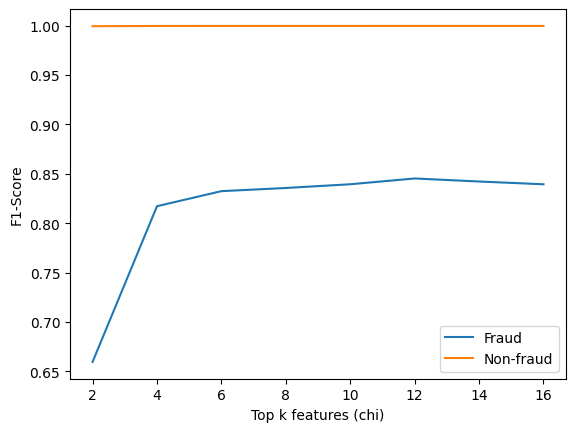

In [33]:
l = [2 + i*2 for i in range(len(xgb_scores['chi']['1f1-score']))]
plt.plot([str(i) for i in l], xgb_scores['chi']['1f1-score'])
plt.plot([str(i) for i in l], xgb_scores['chi']['0f1-score'])
plt.legend(['Fraud', 'Non-fraud'])
plt.xlabel('Top k features (chi)')
plt.ylabel('F1-Score')

Text(0, 0.5, 'F1-Score')

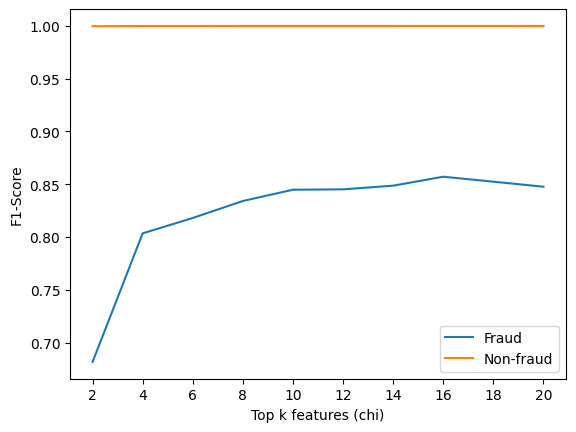

In [35]:
l = [2 + i*2 for i in range(len(xgb_scores['anova']['1f1-score']))]
plt.plot([str(i) for i in l], xgb_scores['anova']['1f1-score'])
plt.plot([str(i) for i in l], xgb_scores['anova']['0f1-score'])
plt.legend(['Fraud', 'Non-fraud'])
plt.xlabel('Top k features (anova)')
plt.ylabel('F1-Score')

Text(0, 0.5, 'F1-Score')

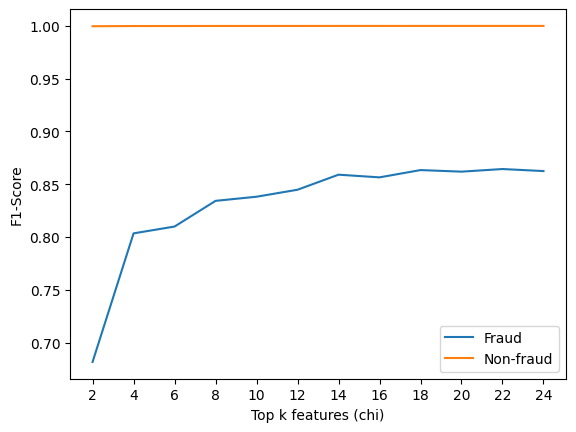

In [34]:
l = [2 + i*2 for i in range(len(xgb_scores['import']['1f1-score']))]
plt.plot([str(i) for i in l], xgb_scores['import']['1f1-score'])
plt.plot([str(i) for i in l], xgb_scores['import']['0f1-score'])
plt.legend(['Fraud', 'Non-fraud'])
plt.xlabel('Top k features (importance)')
plt.ylabel('F1-Score')

In [37]:
for i in mmscaled_importances[:14].feature:
    print(i)

V17
V14
V12
V10
V11
V16
V4
V3
V18
V9
V7
V2
V21
V27


In [33]:
df_feature_selected=copy.deepcopy(df)
x = df_feature_selected[mmscaled_importances[:14].feature]
y = df_feature_selected.Class
xgb = XGBClassifier(random_state=0, n_jobs=-1)
xgb_feature_selected_class_rpt, xgb_feature_selected_roc_auc = cross_validation(xgb, x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)
============================== new fold ============================


<ipython-input-5-33ff7be350eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pid'] = [i+1 for i in range(x.shape[0])]


fitting model
predicting result
prediction distribution
0    56885
1       77
Name: count, dtype: int64
============================== new fold ============================


<ipython-input-5-33ff7be350eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pid'] = [i+1 for i in range(x.shape[0])]


fitting model
predicting result
prediction distribution
0    56879
1       83
Name: count, dtype: int64
============================== new fold ============================


<ipython-input-5-33ff7be350eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pid'] = [i+1 for i in range(x.shape[0])]


fitting model
predicting result
prediction distribution
0    56879
1       82
Name: count, dtype: int64
============================== new fold ============================
fitting model


<ipython-input-5-33ff7be350eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pid'] = [i+1 for i in range(x.shape[0])]


predicting result
prediction distribution
0    56880
1       81
Name: count, dtype: int64
============================== new fold ============================
fitting model


<ipython-input-5-33ff7be350eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pid'] = [i+1 for i in range(x.shape[0])]


predicting result
prediction distribution
0    56873
1       88
Name: count, dtype: int64


In [34]:
xgb_feature_selected_class_rpt, xgb_feature_selected_roc_auc

({'0': {'precision': 0.9996518971253507,
   'recall': 0.9999366899389761,
   'f1-score': 0.9997942721263797,
   'support': 56863.0},
  '1': {'precision': 0.956648143742864,
   'recall': 0.7988662131519275,
   'f1-score': 0.8702197262099947,
   'support': 98.4},
  'accuracy': 0.999589195687499,
  'macro avg': {'precision': 0.9781500204341074,
   'recall': 0.8994014515454519,
   'f1-score': 0.9350069991681873,
   'support': 56961.399999999994},
  'weighted avg': {'precision': 0.9995776496856645,
   'recall': 0.999589195687499,
   'f1-score': 0.9995703625316519,
   'support': 56961.399999999994}},
 0.9771011838560155)

In [35]:
for label in ('0', '1'):
    print()
    print('Label: {}'.format(label))
    for metrics in ('precision', 'recall', 'f1-score'):
        print('{}: {}  -->  {}'.format(metrics, xgb_baseline_class_rpt[label][metrics], xgb_feature_selected_class_rpt[label][metrics]))


Label: 0
precision: 0.9996483863284472  -->  0.9996518971253507
recall: 0.9999472416158135  -->  0.9999366899389761
f1-score: 0.9997977900629433  -->  0.9997942721263797

Label: 1
precision: 0.964272481447306  -->  0.956648143742864
recall: 0.7968253968253969  -->  0.7988662131519275
f1-score: 0.8719423595239792  -->  0.8702197262099947


## AHC Model

In [8]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

tmp = df.Class.to_numpy()
features = ['V17', 'V14', 'V12', 'V10', 'V11', 'V16', 'V4', 'V3', 'V18', 'V9', 'V7', 'V2', 'V21', 'V27', 'Class']
features2 = ['V17', 'V14', 'V12', 'V10', 'V11', 'V16', 'V4', 'V3', 'Class']
df_fs = df.loc[:, features]
df_fs2 = df.loc[:, features]

df = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:-1]))
df['Class'] = tmp
df['pid'] = np.arange(df.shape[0])+1

df_fs = pd.DataFrame(StandardScaler().fit_transform(df_fs.iloc[:,:-1]))
df_fs['Class'] = tmp
df_fs['pid'] = np.arange(df_fs.shape[0])+1

df_fs2 = pd.DataFrame(StandardScaler().fit_transform(df_fs2.iloc[:,:-1]))
df_fs2['Class'] = tmp
df_fs2['pid'] = np.arange(df_fs2.shape[0])+1

In [39]:
df.Class.value_counts(), df.shape

(Class
 0    284315
 1       492
 Name: count, dtype: int64,
 (284807, 32))

In [40]:
df_fs.Class.value_counts(), df_fs.shape

(Class
 0    284315
 1       492
 Name: count, dtype: int64,
 (284807, 16))

In [6]:
df.Class.value_counts()[0]/df.Class.value_counts()[1]

577.8760162601626

### Model framework

* create_clustering_test_data: To prepare datasets for fitting in different size by randomly sampling data points from the datasets.

In [4]:
class agglo_clustering:
    def __init__(self, df_, major_n, minor_n, fold=5):
        self.df=copy.deepcopy(df_)
        self.major_n=major_n
        self.minor_n=minor_n
        self.fold=fold

    def create_clustering_test_data(self):
        #tmp = self.df.Class.to_numpy()
        #self.df = pd.DataFrame(StandardScaler().fit_transform(self.df.iloc[:,:-1]))
        #self.df['Class'] = tmp
        #self.df['pid'] = np.arange(self.df.shape[0])+1
        self.df_=copy.deepcopy(self.df)
        major_N = (self.df.Class==0).sum()
        minor_N = (self.df.Class==1).sum()
        self.testsets=[]
        for i in range(self.fold):
            major = self.df[self.df.Class==0].sample(n=self.major_n, replace=self.major_n>major_N)
            minor = self.df[self.df.Class==1].sample(n=self.minor_n, replace=self.minor_n>minor_N)
            self.testsets.append(pd.concat([major, minor]).sample(frac=1))
            if self.major_n*self.fold<=major_N:
                self.df = self.df[~(self.df.pid.isin(major.pid))]
            if self.minor_n*self.fold<=minor_N:
                self.df = self.df[~(self.df.pid.isin(minor.pid))]
        return

    def cross_validation(self, classifier):
        self.matrix=[]
        self.result_df = self.df_[['pid', 'Class']]
        self.time_spent = np.array([])
        self.rpts = {'0':{'precision':[], 'recall':[], 'f1-score':[], 'support':[]}, 
                     '1':{'precision':[], 'recall':[], 'f1-score':[], 'support':[]}}
        for i, data in tqdm(enumerate(self.testsets)):
            start_time = time.time()
            classifier.fit(data.iloc[:,:-2])
            pred = classifier.labels_
            if np.bincount(pred)[0]<np.bincount(pred)[1]:
                pred = 1-pred
            data['pred{}'.format(i+1)] = pred
            self.result_df = pd.concat([self.result_df, data[['pred{}'.format(i+1)]]], axis=1)
            self.matrix.append((pd.DataFrame({'pred':pred, 'actual':data.Class})).value_counts())
            for label, rpt in self.rpts.items():
                rpt['precision'].append(precision_score(data.Class, pred, pos_label=int(label)))
                rpt['recall'].append(recall_score(data.Class, pred, pos_label=int(label)))
                rpt['f1-score'].append(f1_score(data.Class, pred, pos_label=int(label)))
                rpt['support'].append((data.Class==int(label)).sum())
            self.time_spent=np.append(self.time_spent, time.time()-start_time)
        print("---Average time: {:.3f}s------------------Total time: {:.3f}s-------------------- K: {}".format(np.mean(self.time_spent), np.sum(self.time_spent), self.fold))
        return

    def result_handling(self):
        self.result_df['pred_correct_count']=0
        self.result_df['pred_count']=0
        for i in range(1,self.fold+1):
            self.result_df.pred_correct_count += ((self.result_df.Class==self.result_df['pred{}'.format(i)]) & ~np.isnan(self.result_df['pred{}'.format(i)])).astype(int)
            self.result_df.pred_count += (~np.isnan(self.result_df['pred{}'.format(i)])).astype(int)
    
    def print_rpts(self):
        print('Majority size: {}       Minority size: {}            Imbalance Ratio: {}'.format(self.major_n, self.minor_n, self.major_n//self.minor_n))
        print('      precision            recall             f1-score                support       (std)')
        for label, rpt in self.rpts.items():
            print('{}    {:.2f} ({:.2f})         {:.2f} ({:.2f})          {:.2f} ({:.2f})           {:.1f} ({:.2f})'
                  .format(label, np.mean(rpt['precision']), np.std(rpt['precision']),
                            np.mean(rpt['recall']), np.std(rpt['recall']),
                            np.mean(rpt['f1-score']), np.std(rpt['f1-score']),
                            np.mean(rpt['support']), np.std(rpt['support'])))

In [5]:
# To test how the data size affect the clustering result, variation of size is tested
# To validate the result, K datasets for each data size are created and clustered
majority_class_size = [50,250,500,750,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,7500,10000,12500,15000,20000,25000]
minority_class_size = [1,5,10,15,20,30,40,50,60,70,80,90,100,120,150,200,250,300,400,492]
#features = ['V17', 'V14', 'V12', 'V10', 'V11', 'V16', 'V4', 'V3', 'V18', 'V9', 'V7', 'V2', 'V21', 'V27', 'Class']
#K = [500,150,50,40,25,20,15,12,10,8,8,6,6,6,6,5,5,5,5,5]
agglo = AgglomerativeClustering(linkage='ward')

In [ ]:
#os.remove("agglo_models1")

In [44]:
model_results=[]
model_rpts=[]
for i in range(len(minority_class_size)):
    model = agglo_clustering(df_fs,majority_class_size[i],minority_class_size[i],100)
    model.create_clustering_test_data()
    model.cross_validation(agglo)
    model.print_rpts()
    model.result_handling()
    model_results.append(model.result_df)
    model_rpts.append(model.rpts)

100it [00:13,  7.45it/s]


---Average time: 0.133s------------------Total time: 13.346s-------------------- K: 100
Majority size: 50       Minority size: 1            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.01)         0.98 (0.05)          0.99 (0.03)           50.0 (0.00)
1    0.72 (0.44)         0.75 (0.43)          0.72 (0.44)           1.0 (0.00)


100it [00:14,  7.10it/s]


---Average time: 0.140s------------------Total time: 14.005s-------------------- K: 100
Majority size: 250       Minority size: 5            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.01)         1.00 (0.00)          1.00 (0.00)           250.0 (0.00)
1    0.94 (0.22)         0.58 (0.29)          0.68 (0.27)           5.0 (0.00)


100it [00:14,  6.84it/s]


---Average time: 0.145s------------------Total time: 14.543s-------------------- K: 100
Majority size: 500       Minority size: 10            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           500.0 (0.00)
1    0.98 (0.11)         0.60 (0.24)          0.72 (0.20)           10.0 (0.00)


100it [00:15,  6.30it/s]


---Average time: 0.158s------------------Total time: 15.789s-------------------- K: 100
Majority size: 750       Minority size: 15            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           750.0 (0.00)
1    0.99 (0.04)         0.61 (0.24)          0.72 (0.20)           15.0 (0.00)


100it [00:16,  5.89it/s]


---Average time: 0.169s------------------Total time: 16.901s-------------------- K: 100
Majority size: 1000       Minority size: 20            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           1000.0 (0.00)
1    0.97 (0.05)         0.61 (0.23)          0.72 (0.20)           20.0 (0.00)


100it [00:21,  4.61it/s]


---Average time: 0.216s------------------Total time: 21.609s-------------------- K: 100
Majority size: 1500       Minority size: 30            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.01)         1.00 (0.00)          1.00 (0.00)           1500.0 (0.00)
1    0.97 (0.10)         0.63 (0.25)          0.73 (0.22)           30.0 (0.00)


100it [00:27,  3.58it/s]


---Average time: 0.278s------------------Total time: 27.797s-------------------- K: 100
Majority size: 2000       Minority size: 40            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           2000.0 (0.00)
1    0.97 (0.10)         0.62 (0.23)          0.73 (0.20)           40.0 (0.00)


100it [00:36,  2.72it/s]


---Average time: 0.367s------------------Total time: 36.678s-------------------- K: 100
Majority size: 2500       Minority size: 50            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           2500.0 (0.00)
1    0.97 (0.10)         0.61 (0.24)          0.72 (0.21)           50.0 (0.00)


100it [00:54,  1.84it/s]


---Average time: 0.544s------------------Total time: 54.380s-------------------- K: 100
Majority size: 3000       Minority size: 60            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           3000.0 (0.00)
1    0.98 (0.02)         0.69 (0.20)          0.79 (0.17)           60.0 (0.00)


100it [01:10,  1.41it/s]


---Average time: 0.707s------------------Total time: 70.730s-------------------- K: 100
Majority size: 3500       Minority size: 70            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           3500.0 (0.00)
1    0.98 (0.03)         0.68 (0.20)          0.78 (0.17)           70.0 (0.00)


100it [01:29,  1.11it/s]


---Average time: 0.897s------------------Total time: 89.681s-------------------- K: 100
Majority size: 4000       Minority size: 80            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           4000.0 (0.00)
1    0.98 (0.02)         0.68 (0.21)          0.78 (0.18)           80.0 (0.00)


100it [01:51,  1.11s/it]


---Average time: 1.110s------------------Total time: 111.031s-------------------- K: 100
Majority size: 4500       Minority size: 90            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           4500.0 (0.00)
1    0.98 (0.02)         0.66 (0.22)          0.76 (0.19)           90.0 (0.00)


100it [02:15,  1.36s/it]


---Average time: 1.356s------------------Total time: 135.649s-------------------- K: 100
Majority size: 5000       Minority size: 100            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           5000.0 (0.00)
1    0.98 (0.02)         0.68 (0.23)          0.77 (0.19)           100.0 (0.00)


100it [03:14,  1.95s/it]


---Average time: 1.949s------------------Total time: 194.866s-------------------- K: 100
Majority size: 6000       Minority size: 120            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           6000.0 (0.00)
1    0.98 (0.02)         0.70 (0.19)          0.80 (0.16)           120.0 (0.00)


100it [05:09,  3.09s/it]


---Average time: 3.094s------------------Total time: 309.375s-------------------- K: 100
Majority size: 7500       Minority size: 150            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           7500.0 (0.00)
1    0.98 (0.01)         0.74 (0.16)          0.83 (0.13)           150.0 (0.00)


100it [09:35,  5.75s/it]


---Average time: 5.752s------------------Total time: 575.240s-------------------- K: 100
Majority size: 10000       Minority size: 200            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           10000.0 (0.00)
1    0.98 (0.01)         0.74 (0.15)          0.83 (0.13)           200.0 (0.00)


100it [15:48,  9.48s/it]


---Average time: 9.480s------------------Total time: 948.011s-------------------- K: 100
Majority size: 12500       Minority size: 250            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           12500.0 (0.00)
1    0.98 (0.01)         0.76 (0.13)          0.85 (0.11)           250.0 (0.00)


100it [23:50, 14.30s/it]


---Average time: 14.300s------------------Total time: 1430.013s-------------------- K: 100
Majority size: 15000       Minority size: 300            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           15000.0 (0.00)
1    0.98 (0.01)         0.76 (0.13)          0.85 (0.10)           300.0 (0.00)


100it [47:45, 28.66s/it]


---Average time: 28.657s------------------Total time: 2865.727s-------------------- K: 100
Majority size: 20000       Minority size: 400            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           20000.0 (0.00)
1    0.98 (0.01)         0.75 (0.13)          0.84 (0.11)           400.0 (0.00)


100it [1:24:59, 51.00s/it]


---Average time: 50.995s------------------Total time: 5099.501s-------------------- K: 100
Majority size: 25000       Minority size: 492            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           25000.0 (0.00)
1    0.98 (0.01)         0.79 (0.01)          0.88 (0.00)           492.0 (0.00)


In [45]:
fi1 = open("agglo_model_results", "wb")
pickle.dump(model_results, fi1)
fi1.close()

fi2 = open("agglo_model_rpts", "wb")
pickle.dump(model_rpts, fi2)
fi2.close()

Text(0, 0.5, 'Precision/Recall')

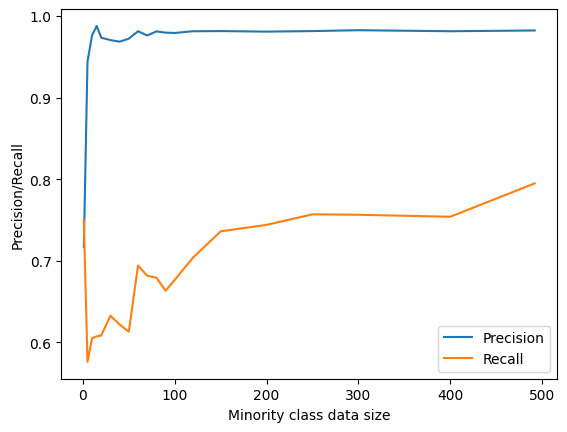

In [46]:
plt.plot(minority_class_size, [np.mean(model_rpt['1']['precision']) for model_rpt in model_rpts])
plt.plot(minority_class_size, [np.mean(model_rpt['1']['recall']) for model_rpt in model_rpts])
plt.legend(['Precision', 'Recall'])
plt.xlabel('Minority class data size')
plt.ylabel('Precision/Recall')

In [45]:
model_results=[]
model_rpts=[]
for i in range(len(minority_class_size)):
    model = agglo_clustering(df_fs2,majority_class_size[i],minority_class_size[i],100)
    model.create_clustering_test_data()
    model.cross_validation(agglo)
    model.print_rpts()
    model.result_handling()
    model_results.append(model.result_df)
    model_rpts.append(model.rpts)

100it [00:14,  6.78it/s]


---Average time: 0.147s------------------Total time: 14.668s-------------------- K: 100
Majority size: 50       Minority size: 1            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.01)         0.96 (0.09)          0.98 (0.06)           50.0 (0.00)
1    0.83 (0.35)         0.93 (0.26)          0.84 (0.33)           1.0 (0.00)


100it [00:14,  6.73it/s]


---Average time: 0.148s------------------Total time: 14.785s-------------------- K: 100
Majority size: 250       Minority size: 5            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.01)         1.00 (0.00)          1.00 (0.00)           250.0 (0.00)
1    0.97 (0.10)         0.67 (0.27)          0.76 (0.21)           5.0 (0.00)


100it [00:15,  6.48it/s]


---Average time: 0.153s------------------Total time: 15.343s-------------------- K: 100
Majority size: 500       Minority size: 10            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           500.0 (0.00)
1    0.98 (0.06)         0.67 (0.23)          0.77 (0.19)           10.0 (0.00)


100it [00:16,  6.12it/s]


---Average time: 0.163s------------------Total time: 16.269s-------------------- K: 100
Majority size: 750       Minority size: 15            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           750.0 (0.00)
1    0.99 (0.04)         0.68 (0.22)          0.78 (0.18)           15.0 (0.00)


100it [00:17,  5.69it/s]


---Average time: 0.175s------------------Total time: 17.495s-------------------- K: 100
Majority size: 1000       Minority size: 20            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           1000.0 (0.00)
1    0.98 (0.04)         0.66 (0.21)          0.77 (0.17)           20.0 (0.00)


100it [00:21,  4.58it/s]


---Average time: 0.217s------------------Total time: 21.713s-------------------- K: 100
Majority size: 1500       Minority size: 30            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           1500.0 (0.00)
1    0.98 (0.03)         0.70 (0.19)          0.80 (0.16)           30.0 (0.00)


100it [00:27,  3.62it/s]


---Average time: 0.275s------------------Total time: 27.493s-------------------- K: 100
Majority size: 2000       Minority size: 40            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    0.99 (0.00)         1.00 (0.00)          1.00 (0.00)           2000.0 (0.00)
1    0.98 (0.03)         0.73 (0.18)          0.82 (0.14)           40.0 (0.00)


100it [00:35,  2.80it/s]


---Average time: 0.356s------------------Total time: 35.611s-------------------- K: 100
Majority size: 2500       Minority size: 50            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           2500.0 (0.00)
1    0.98 (0.02)         0.75 (0.15)          0.84 (0.12)           50.0 (0.00)


100it [00:45,  2.19it/s]


---Average time: 0.455s------------------Total time: 45.483s-------------------- K: 100
Majority size: 3000       Minority size: 60            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           3000.0 (0.00)
1    0.98 (0.02)         0.75 (0.14)          0.84 (0.11)           60.0 (0.00)


100it [01:05,  1.52it/s]


---Average time: 0.659s------------------Total time: 65.862s-------------------- K: 100
Majority size: 3500       Minority size: 70            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           3500.0 (0.00)
1    0.98 (0.02)         0.76 (0.14)          0.84 (0.11)           70.0 (0.00)


100it [01:24,  1.19it/s]


---Average time: 0.842s------------------Total time: 84.181s-------------------- K: 100
Majority size: 4000       Minority size: 80            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           4000.0 (0.00)
1    0.98 (0.02)         0.76 (0.14)          0.84 (0.12)           80.0 (0.00)


100it [01:44,  1.05s/it]


---Average time: 1.047s------------------Total time: 104.692s-------------------- K: 100
Majority size: 4500       Minority size: 90            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           4500.0 (0.00)
1    0.98 (0.02)         0.76 (0.12)          0.85 (0.09)           90.0 (0.00)


100it [02:08,  1.29s/it]


---Average time: 1.286s------------------Total time: 128.642s-------------------- K: 100
Majority size: 5000       Minority size: 100            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           5000.0 (0.00)
1    0.98 (0.02)         0.77 (0.11)          0.86 (0.09)           100.0 (0.00)


100it [03:03,  1.84s/it]


---Average time: 1.838s------------------Total time: 183.761s-------------------- K: 100
Majority size: 6000       Minority size: 120            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           6000.0 (0.00)
1    0.98 (0.02)         0.76 (0.14)          0.85 (0.11)           120.0 (0.00)


100it [04:54,  2.95s/it]


---Average time: 2.945s------------------Total time: 294.463s-------------------- K: 100
Majority size: 7500       Minority size: 150            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           7500.0 (0.00)
1    0.98 (0.01)         0.77 (0.12)          0.86 (0.09)           150.0 (0.00)


100it [09:33,  5.73s/it]


---Average time: 5.731s------------------Total time: 573.113s-------------------- K: 100
Majority size: 10000       Minority size: 200            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           10000.0 (0.00)
1    0.98 (0.01)         0.78 (0.10)          0.86 (0.08)           200.0 (0.00)


100it [16:17,  9.78s/it]


---Average time: 9.776s------------------Total time: 977.558s-------------------- K: 100
Majority size: 12500       Minority size: 250            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           12500.0 (0.00)
1    0.98 (0.01)         0.79 (0.08)          0.87 (0.07)           250.0 (0.00)


100it [24:56, 14.96s/it]


---Average time: 14.961s------------------Total time: 1496.096s-------------------- K: 100
Majority size: 15000       Minority size: 300            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           15000.0 (0.00)
1    0.98 (0.01)         0.78 (0.09)          0.87 (0.08)           300.0 (0.00)


100it [48:53, 29.33s/it]


---Average time: 29.332s------------------Total time: 2933.181s-------------------- K: 100
Majority size: 20000       Minority size: 400            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           20000.0 (0.00)
1    0.98 (0.01)         0.80 (0.04)          0.88 (0.03)           400.0 (0.00)


100it [1:23:09, 49.90s/it]


---Average time: 49.898s------------------Total time: 4989.808s-------------------- K: 100
Majority size: 25000       Minority size: 492            Imbalance Ratio: 50
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           25000.0 (0.00)
1    0.98 (0.01)         0.80 (0.00)          0.88 (0.00)           492.0 (0.00)


In [46]:
fi1 = open("agglo_model_results", "wb")
pickle.dump(model_results, fi1)
fi1.close()

fi2 = open("agglo_model_rpts", "wb")
pickle.dump(model_rpts, fi2)
fi2.close()

Text(0, 0.5, 'Precision/Recall')

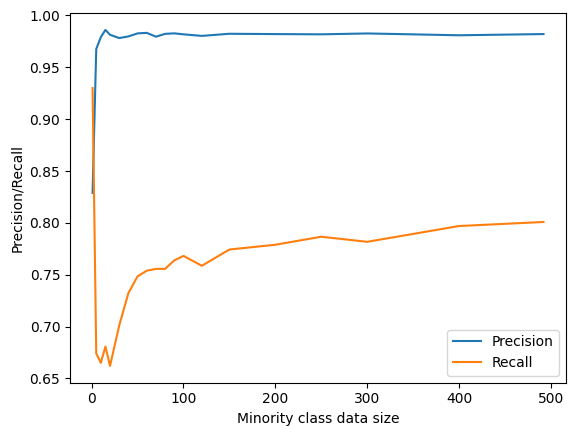

In [47]:
plt.plot(minority_class_size, [np.mean(model_rpt['1']['precision']) for model_rpt in model_rpts])
plt.plot(minority_class_size, [np.mean(model_rpt['1']['recall']) for model_rpt in model_rpts])
plt.legend(['Precision', 'Recall'])
plt.xlabel('Minority class data size')
plt.ylabel('Precision/Recall')

In [9]:
majority_class_size2 = [500,5000,10000,25000,50000,100000,250000]
minority_class_size2 = [1,10,20,50,100,200,492]

In [ ]:
model2_results = []
model2_rpts=[]
for i in range(len(minority_class_size)):
    model2 = agglo_clustering(df_fs,majority_class_size2[i],minority_class_size2[i],5)
    model2.create_clustering_test_data()
    model2.cross_validation(agglo)
    model2.print_rpts()
    model2.result_handling()
    model2_results.append(model2.result_df)
    model2_rpts.append(model2.rpts)

5it [00:00, 21.35it/s]


---Average time: 0.046s------------------Total time: 0.232s-------------------- K: 5
Majority size: 500       Minority size: 1            Imbalance Ratio: 500
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         1.00 (0.00)          1.00 (0.00)           500.0 (0.00)
1    0.40 (0.49)         0.40 (0.49)          0.40 (0.49)           1.0 (0.00)


5it [00:05,  1.17s/it]


---Average time: 1.173s------------------Total time: 5.865s-------------------- K: 5
Majority size: 5000       Minority size: 10            Imbalance Ratio: 500
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         0.97 (0.05)          0.99 (0.03)           5000.0 (0.00)
1    0.71 (0.36)         0.60 (0.36)          0.62 (0.33)           10.0 (0.00)


5it [00:26,  5.38s/it]


---Average time: 5.381s------------------Total time: 26.905s-------------------- K: 5
Majority size: 10000       Minority size: 20            Imbalance Ratio: 500
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         0.95 (0.06)          0.97 (0.03)           10000.0 (0.00)
1    0.53 (0.44)         0.38 (0.33)          0.42 (0.36)           20.0 (0.00)


5it [03:40, 44.10s/it]


---Average time: 44.102s------------------Total time: 220.508s-------------------- K: 5
Majority size: 25000       Minority size: 50            Imbalance Ratio: 500
      precision            recall             f1-score                support       (std)
0    1.00 (0.00)         0.92 (0.06)          0.96 (0.03)           25000.0 (0.00)
1    0.34 (0.42)         0.12 (0.14)          0.18 (0.22)           50.0 (0.00)


0it [00:00, ?it/s]

In [ ]:
fi1 = open("agglo_model2_results", "wb")
pickle.dump(model2_results, fi1)
fi1.close()

fi2 = open("agglo_model2_rpts", "wb")
pickle.dump(model2_rpts, fi2)
fi2.close()

In [ ]:
plt.plot(minority_class_size2, [np.mean(model2_rpt['1']['precision']) for model2_rpt in model2_rpts])
plt.plot(minority_class_size2, [np.mean(model2_rpt['1']['recall']) for model2_rpt in model2_rpts])
plt.legend(['Precision', 'Recall'])
plt.xlabel('Minority class data size')
plt.ylabel('Precision/Recall')

In [ ]:
file = open("/kaggle/input/testsave/agglo_models1",'rb')
results = pickle.load(file)